In [1]:
import math as m
import numpy as np
import pandas as pd
import requests

import scipy.interpolate as int1d
from scipy.sparse import *
from scipy.linalg.lapack  import  dgtsv  as  lapack_dgtsv

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import time, sys

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import matplotlib.ticker as ticker
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rc('text', usetex=True)  # switch to True for latex font (might be slow)
rcParams.update({"xtick.major.size": 6, "xtick.minor.size": 3, "ytick.major.size": 6, "ytick.minor.size": 3, 
                 'xtick.direction': 'in', 'ytick.direction': 'in', 'xtick.top': True, 'ytick.right': True, 
                 'font.size': 16})

# DNS is stored there:
dataRepo = 'https://raw.githubusercontent.com/Fluid-Dynamics-Of-Energy-Systems-Team/RANS_Channel/master/DNS_data/'


# RANS solver for fully developed compressible turbulent channel flows
 
             Created on: Dec, 2018
                Authors: Rene Pecnik (R.Pecnik@tudelft.nl)
                         Asif M. Hasan (a.m.hasan@tudelft.nl)
                         Gustavo J. Otero R. (G.J.OteroRodriguez@tudelft.nl)
                         Process & Energy Department, Faculty of 3mE
                         Delft University of Technology, the Netherlands.

       Last modified on: Oct, 2023
                     by: Rene Pecnik 
                     
The detailed derivation and implementation, including the compressiblity corrections for several turbulence models, is outlined in the corresponding publication: 
 * __[Otero et al., 2017. Heat and fluid flow](https://www.sciencedirect.com/science/article/pii/S0142727X18301978)__, 

# Velocity transformations

#### Van Driest velocity transformation

$$ u^{vD} = \int_0^{u^+} \sqrt{\frac{\rho}{\rho_w}}d u^+$$

#### Velocity transformation based on semi-local scaling, Patel et al., 2016, JFM

$$ u^\star = \int_0^{u^+} \left[1 + \frac{y}{Re_\tau^\star}\frac{d Re_\tau^\star}{dy} \right]\sqrt{\frac{\rho}{\rho_w}}d u^+$$

In [2]:
def velTransVD(upl,rho,ReTau,mesh):

    n   = mesh.n
    uvd = np.zeros(n)
    ypl = mesh.y*ReTau
    
    for i in range(1,n):
        uvd[i] = uvd[i-1] + np.sqrt(0.5*(rho[i]+rho[i-1])/rho[0])*(upl[i]-upl[i-1])
        
    return ypl,uvd

def velTransSLS(upl,rho,mu,ReTau,mesh):

    n = mesh.n

    # Calculate correction factor of semi-local velocity transformation
    ReTauStar = ReTau*np.sqrt(rho/rho[0])/(mu/mu[0])
    fact      = 1 + mesh.y/ReTauStar*(mesh.ddy@ReTauStar)

    ystar = mesh.y*ReTauStar
    ypl, uvd = velTransVD(upl,rho,ReTau,mesh)
    
    ustar = np.zeros(n)
    for i in range(1,n):
        ustar[i] = ustar[i-1] + 0.5*(fact[i]+fact[i-1])*(uvd[i]-uvd[i-1])

    return ystar,ustar

# Mesh 
     y=0                          y=H/2                          y=H
       || |  |   |    |      |      |      |      |    |   |  | ||
       xx x  x   x    x      x      x      x      x    x   x  x xx
       || |  |   |    |      |      |      |      |    |   |  | ||
     i=0                                                         i=n-1

The wall-normal coordinate for the channel is computed as:

$$ y(i) = \frac{H}{2}  \left(1.0 + \frac{\tanh\left(s \left(\frac{i}{n-1}-\frac{1}{2}\right)\right)}{\tanh(s / 2)}\right),$$

where $s$ is a stretching factor. 

### Derivatives
The derivatives on the non-uniform mesh are computed with a mesh transformation.

The first derivative is then 

$$ \frac{d(\cdot)}{dy} = \frac{di}{dy} \frac{d(\cdot)}{di} = \frac{1}{(dy/di)} \frac{d(\cdot)}{di},$$
with $dy/di$ the derivative of $y$ with respect to $i$.

The second derivative is 

$$ \frac{d^2(\cdot) }{dy^2} = \frac{1}{(dy/di)^2} \frac{d^2(\cdot)}{di^2} - \frac{1}{(dy/di)^3} \frac{d^2y}{di^2}\frac{d(\cdot)}{di}. $$

### Function to solve a linear system with under-relaxation

The linear system is
$$ A\phi = b $$
Using an under-relaxation parameter $\omega$, the system can also be written as
$$ \left(A - \frac{1-\omega}{\omega}A_{ii}\right)\phi_{new} = b - \frac{1-\omega}{\omega}A_{ii}\phi_{old} $$

In [3]:
def finiteDiffCoeff(x,k):

    x = np.array(x)
    n = np.size(x)
    A = np.ones((n,n))

    for i in range(1, n):
        A[i,:] = pow(x,i)/m.factorial(i)

    b = np.zeros((n,1))            # b is right hand side,
    b[k] = 1                       # so k'th derivative term remains
    sol  = np.linalg.solve(A, b)   # solve system for coefficients
    return sol.transpose()


class Mesh:

    def __init__(self, 
                 n,       # Number of mesh points 
                 H,       # channel height
                 s):      # factor to set mesh clustering at the wall

        self.n = n

        di = 1.0/(n-1)
        i = (np.linspace(0,n-1,n))/(n-1) - 0.5
        
        # y - coordinate: tanh clustering at the walls
        self.y = H * (1.0 + np.tanh(s*i)/np.tanh(s/2))/2.0
        
        # first derivative of y with respect to 'i'
        dydi =  H/(n-1) * s/2.0/np.tanh(s/2)/np.power(np.cosh(s*i), 2.0)
        
        # second derivative of y with respect to 'i'
        d2ydi2 = -H/(n-1)**2 * np.power(s,2.0)/np.tanh(s/2)*np.tanh(s*i)/np.power(np.cosh(s*i),2.0)
                
        # ---------------------------------------------------------------------------------------------------
        #
        # First derivative: coefficient matrix for d()/dy = 1/(dy/di) * d()/di
        #
        ddy                = np.zeros((n,n))
        ddy[0,  0:7]       = finiteDiffCoeff(np.arange( 0,7), 1)   # higher-order, one-sided at the boundary
        ddy[n-1,n-7:n]     = finiteDiffCoeff(np.arange(-6,1), 1)   # higher-order, one-sided at the boundary
        for i in range(1,n-1):
            ddy[i,i-1:i+2] = [-0.5, 0, 0.5]                        # second order for all points within the domain 
        self.ddy = diags(1/dydi)@csr_matrix(ddy)                   # multiply coordinate transf. and store sparse matrix

        
        # ---------------------------------------------------------------------------------------------------
        #
        # Second derivative: coefficient matrix for d2()/dy2 = 1/(dy/di)^2*d2()/di2 - 1/(dy/di)^3*d2y/di2*d()/di
        #
        d2dy2                = np.zeros((n,n))
        d2dy2[0,  0:7  ]     = finiteDiffCoeff(np.arange( 0,7), 2)   # higher-order, one-sided at the boundary
        d2dy2[n-1,n-7:n]     = finiteDiffCoeff(np.arange(-6,1), 2)   # higher-order, one-sided at the boundary
        for i in range(1,n-1):
            d2dy2[i,i-1:i+2] = [ 1., -2.,  1.]                       # second order for all points within the domain 
        self.d2dy2 = diags(1/dydi**2.0)@csr_matrix(d2dy2) - diags(d2ydi2/dydi**2)@self.ddy


    def solveEqn(self,x,A,b,omega):

        x_new = x.copy()

        b[0]  -= x[0]*A[1,0]     # boundary condition at y=0
        b[-1] -= x[-1]*A[-2,-1]  # boundary condition at y=H

        if (omega < 1.0):
            b[:] += (1-omega)/omega * A.diagonal()[1:-1]*x[1:-1]
            A.setdiag(A.diagonal()/omega)

        # x_new[1:-1] = linalg.spsolve(A[1:-1, 1:-1], b)
        
        x_new[1:-1] = lapack_dgtsv(A.diagonal(-1)[1:-1],
                                   A.diagonal( 0)[1:-1],
                                   A.diagonal( 1)[1:-1], b)[-2]

        return x_new

# Read data from DNS 
### Data from Patel et al., JFM (2016)

In [4]:
def loadAPdata(file):
    
    line = requests.get(file).content.decode('utf-8').splitlines()[38].split()
    ReTau  = float(line[1]);    print("ReTau  = ", ReTau)     # Reynolds number
    Pr     = float(line[2]);    print("Pr     = ", Pr)        # Prandtl number
    expRho = float(line[3]);    print("expRho = ", expRho)    # temperature exponent for density 
    expMu  = float(line[4]);    print("expMu  = ", expMu)     # temperature exponent for viscosity 
    expLam = float(line[5]);    print("expLam = ", expLam)    # temperature exponent for conductivity 
    Qvol   = float(line[6]);    print("Qvol   = ", Qvol)      # volmetric heating
    
    # load dns data
    DNS = pd.read_csv(file, comment='#')

    rk  = 0.5*(DNS['<rho>{u\"u\"}'] + DNS['<rho>{v\"v\"}'] + DNS['<rho>{w\"w\"}'])
    ruv = DNS['<rho>{u\"v\"}']
    
    uTS = DNS['Ret*']*DNS['<mu>']/DNS['<rho>']
    scal = DNS['<rho>'] * uTS**3 * DNS['Ret*']

    eps = DNS['eps']/scal
    try:
        epsSLS = DNS['epsSLS']/DNS['Ret*']
    except:
        epsSLS = np.zeros_like(eps)
    
    return {'ReTau':ReTau, 'Pr':Pr, 'expRho':expRho, 'expMu':expMu, 'expLam':expLam, 'Qvol':Qvol, 
            'y':DNS['y'], 'yst':DNS['y*'], 'rho':DNS['<rho>'], 'mu':DNS['<mu>'], 
            'ust':DNS['u*2'], 'rk':rk, 'ruv':ruv, 'eps':eps, 'epsSLS':epsSLS}

# DNS = loadAPdata(dataRepo+"PatelEtAl_constReTauStar.txt")
# # DNS = loadAPdata("DNS_data/PatelEtAl_constReTauStar.txt")
# plt.semilogx(DNS['y'], DNS['epsSLS'])
# plt.semilogx(DNS['y'], DNS['eps'])

### Data from Trettel and Larsson, PoF (2016)

In [5]:
def loadTLdata(file):

    data = requests.get(file).content.decode('utf-8').splitlines()  
    strings = data[54].split();   rhow = float(strings[3]);    print('rhow  = ', rhow)
    strings = data[55].split();   muw  = float(strings[3]);    print('muw   = ', muw)
    strings = data[62].split();   utau = float(strings[3]);    print('utau  = ', utau)
    strings = data[69].split();   ReTau = float(strings[3]);   print('ReTau = ', ReTau)
    strings = data[71].split();   MaTau = float(strings[3]);   print('MaTau = ', MaTau)

    data = pd.read_csv(file, delimiter=',', skiprows=99)
    data.rename(columns=lambda x: x.replace('%','').strip(), inplace=True);     # print(data.columns)
    # print(data.columns)
    y   = data['y']
    ypl = data['y+']
    yst = data['Y+tl']
    rho = data['<rho>']/rhow
    mu  = data['mu']/muw/ReTau
    ust = data['U+tl']

    rk  = 0.5*rho*(data['<u\'\'u\'\'>_f'] + data['<v\'\'v\'\'>_f'] + data['<w\'\'w\'\'>_f'])/(utau**2)
    ruv = rho*data['<u\'\'v\'\'>_f']/(utau**2)

    return {'y':y, 'ypl':ypl, 'yst':yst, 'rho':rho, 'mu':mu, 'ust':ust, 'ReTau':ReTau, 'MaTau':MaTau, 'rk':rk, 'ruv':ruv}

# DNS = loadTLdata(dataRepo+'M4.0R200_data.csv')
# plt.semilogx(DNS['yst'][1:], DNS['mu'][1:], '-')

### Data from Hasan et al., PRF (2023)

In [6]:
def loadHasanData(file):
    # file = 'DNS_data/HasanEtAlMach2.csv'
    conditions  = pd.read_csv(file, nrows=1).to_dict('records')
    data        = pd.read_csv(file, skiprows=3)
    data['y']   = data['yst']/conditions[0]['ReTau']
    data['rho'] = 1.0
    data['mu']  = 1.0/conditions[0]['ReTau']

    return {**(conditions[0]), 'y':data['y'], 'yst':data['yst'], 
                                'ust':data['ust'], 'rho':data['rho'], 'mu':data['mu']}

# df = loadHasanData('DNS_data/HasanEtAlMach2.csv')
# plt.plot(df['y'], df['ust'])

# df = loadHasanData('DNS_data/HasanEtAlMach3.csv')
# plt.semilogx(df['yst'], df['ust'])

# df = loadHasanData('DNS_data/HasanEtAlMach4.csv')
# plt.semilogx(df['yst'], df['ust'],':')

# Momentum equation (fully developed channel)
The streamwise momentum equation of the Reynolds-averaged Navier-Stokes equations for a fully developed turbulent channel flow reads, 

$$ \frac{d}{dy}\left[\left(\mu+\mu_t \right) \frac{du}{dy}\right] = -1,$$ 

with $u$ the streamwise velocity, $\mu$ the dynamic visocity, and $\mu_t$ the Eddy viscosity which is obtained by a solving a turbulence model. Viscous wall units are used to non-dimensionalize the Navier-Stokes equations, hence $-1$ defines the forcing on the right-hand-side. 
Using the product rule, the momentum equation can also be written as 
$$ \left[\frac{d\mu_{eff}}{dy}\frac{d}{dy} + \mu_{eff}\frac{d^2}{dy^2}\right] u = -1, $$ 

with $\mu_{eff} = \mu+\mu_t$. Now it is easy to formulate a linear system $ A u = -1 $ which can be solved using a direct linear solver. 

In [7]:
def solveRANS(mesh         = Mesh(200, 2, 5),  # provide mesh 
              ReTau        = 1000,             # ReTau
              turbModel    = "SA",             # pass string for turbulence model 
              varPropCorr  = "None",           # variable property correction: "OteroEtAl", "CatrisAupoix", "None"
              yDNS         = [],               # if yDNS not empty, use rho and mu from DNS & do not solve temperature eq. 
              rhoDNS       = [],               #   - rho from DNS 
              muDNS        = [],               #   - mu from DNS
              Pr           = 1.0,              # if yDNS empty, solve temperature eq. 
              Prt          = 1.0,              #   - Pr, Prt: molecular and turbulent Prandtl number
              expRho       = 0.0,              #   - expRho, exponent: rho = T**expRho
              expMu        = 0.0,              #   - expMu,  exponent: mu  = T**expMu
              expLam       = 0.0,              #   - expLam, exponent: lam = T**expLam
              Qvol         = 0.0,              #   - Qvol, heat source for Patel et al. cases 
              compressCorr = "None",           # compressibility correction: 
              MaTau        = 0.0,              # turbulence Mach number
              Mach         = 0.0,              # Mach number
              verbose      = False):           # provide more output if verbose is True

    n    = mesh.n
    u    = 1e-6*np.ones(n)      # velocity 
    T    = np.ones(n)           # temperature 

    mut  = np.zeros(n)          # eddy viscosity 
    k    = 0.01*np.ones(n)      # turbulent kinetic energy
    e    = 0.001*np.ones(n)     # turbulent dissipation rate
    v2   = 1/3*k                # equivalent wall-normal turbulent stress for V2F model
    om   = np.ones(n)           # specific turbulent dissipation rate for omega in SST
    nuSA = np.ones(n)/ReTau     # eddy viscisty for SA model

    # if yDNS not empty, use rho and mu from DNS. Interpolate on mesh
    if (len(yDNS) != 0):        
        rho = np.interp(np.minimum(mesh.y, mesh.y[-1]-mesh.y), yDNS, rhoDNS);  rho[0] = rho[-1] = 1.0
        mu  = np.interp(np.minimum(mesh.y, mesh.y[-1]-mesh.y), yDNS, muDNS );   mu[0] =  mu[-1] = 1.0/ReTau

    
    residual   = 1.0e20
    iterations = 0
    
    if (verbose == True): print("Start iterating")

    tic = time.perf_counter()

    while residual > 1.0e-6 and iterations < 10000:

        # Solve temperature:  d/dy[(lam+mut/PrT)dTdy] = -VolQ/ReTau/Pr
        if (len(yDNS) == 0):
            rho, mu, T = solveTemperature(T, mut, ReTau, Pr, Prt, expRho, expMu, expLam, Qvol, mesh)

        # Solve turbulence model to calculate eddy viscosity 
        if   turbModel == "SA":  mut,nuSA   = SA( u, nuSA,            rho, mu,        mesh, varPropCorr)
        elif turbModel == "MK":  mut,k,e    = MK( u, k,    e,         rho, mu, ReTau, mesh, varPropCorr)
        elif turbModel == "SST": mut,k,om   = SST(u, k,    om,     T, rho, mu,        mesh, varPropCorr, compressCorr, Mach)
        elif turbModel == "V2F": mut,k,e,v2 = V2F(u, k,    e,  v2,    rho, mu,        mesh, varPropCorr)
        else:                    mut        = np.zeros(n)

        # Solve momentum equation:  d/dy[mueff*du/dy] = [mueff*d2()/dy2 + d(mueff)/dy*d()/dy]*u = - 1
        # 
        mueff    = mu + mut
        A        = diags(mesh.ddy@mueff)@mesh.ddy + diags(mueff)@mesh.d2dy2
        u_old    = u.copy()
        u        = mesh.solveEqn(u, A, -np.ones(n-2), 1.0)
        residual = np.linalg.norm(u-u_old)/n

        # Print residuals
        if (iterations%100 == 0 and verbose == True): print("iteration: ",iterations, ", Residual(u) = ", residual)
        iterations = iterations + 1

    toc = time.perf_counter()

    if residual > 1.0e-6:
        print(f"NOT CONVERGED! Iteration: {iterations}, Residual(u) = {residual}, Time to run {toc - tic:0.4f} seconds")
    else:
        print(f"CONVERGED! Iteration: {iterations}, Residual(u) = {residual}, Time to run {toc - tic:0.4f} seconds")

    ypl,uvd = velTransVD( u,  rho,    ReTau, mesh)      # van Driest vel. Note, u is already u+ due to normalization
    yst,ust = velTransSLS(u, rho, mu, ReTau, mesh)      # velocity transformation based on semi-locally scaling
    ruv     = -mut*(mesh.ddy@u)                         # turbulent shear stress: ruv = - mut*du/dy

    return {'ypl':ypl, 'yst':yst, 'u':u, 'uvd':uvd, 'ust':ust, 
            'T':T, 'rho':rho, 'mu':mu, 
            'mut':mut, 'ruv':ruv, 'k':k, 'e':e, 'om':om}   # return a dictionary with the most interesting quantities. 

# Temperature equation

The temperature equation (normalized by the wall temperature) for a fully developed channel reads

$$\frac{d}{dy}\left[\left(\lambda+\frac{\mu_t}{Pr_t}\right)\frac{dT}{dy}\right] = -\frac{Q}{Re_\tau Pr}, $$ 

with $\lambda$ the thermal conductivity, $Pr_t$ the turbulent Prandtl number, $Q$ the volumetric heat source, and $Re_\tau$ and $Pr$ the reference Reynolds and Prandtl numbers, respectively. The boundary conditions for the normalized temperature at both walls is 1. Using the temperature, the density $\rho$, dynamic viscosity $\mu$ and thermal conductivity $\lambda$ are then calculated as follows, 
* thermal conductivity: $$\lambda = \frac{T^\mathrm{expLam}}{Re_\tau Pr},$$
* density:  $$\rho = T^\mathrm{expRho},$$
* viscosity: $$\mu = \frac{T^\mathrm{expMu}}{Re_\tau}.$$

The exponents determine the relation of these quantities with temperature. If the purpose is to compare the RANS solution with results from DNS, then the exponents, the reference Reynolds and Prandtl numbers, and the volumetric heat source can be found in the DNS data files in line 39.

In [8]:
def solveTemperature(T, mut, ReTau, Pr, Prt, expRho, expMu, expLam, Qvol, mesh):
    
    n = mesh.n
    
    # molecular thermal conductivity: 
    lam = np.power(T, expLam)/(ReTau*Pr)   
    
    # turbulent Prandtl: assume = 1
    Prt = Prt * np.ones(n)                          

    # diffusion matrix: lamEff*d2phi/dy2 + dlamEff/dy dphi/dy
    lam_eff = lam + mut/Prt   
    A = diags(mesh.ddy@lam_eff)@mesh.ddy + diags(lam_eff)@mesh.d2dy2

    # Isothermal BC
    T[0] = T[-1] = 1              
    
    # source term
    b = -Qvol*np.ones(n-2)/(ReTau*Pr)

    # Solve
    T = mesh.solveEqn(T, A, b, 0.95)

    # calculate density and viscosity from temperature
    r  = np.power(T, expRho)
    mu = np.power(T, expMu)/ReTau
    
    return r, mu, T

# Turbulence models

### Spalart & Allmaras model, 'SA': 
Spalart, A. and Allmaras, S., "One equation turbulence model for aerodynamic flows", Recherche Aerospatiale-French edition, 1994.
> Turbulent scalar equation $\tilde \nu$: $$0 = c_{b1} \hat S \tilde\nu - c_{w1} f_w \left(\frac{\tilde\nu}{y}\right)^2 + \frac{1}{{\color{red}{\rho}}c_{b3}} \frac{d}{dy}\left[{\color{red}{\rho}}\left(\nu+\tilde\nu\right) \frac{d \tilde\nu}{dy} + {\color{red}{\left(\nu+\tilde\nu\right) \frac{\tilde\nu}{2}\frac{d \rho}{dy}}}\right] + \frac{c_{b2}}{{\color{red}{\rho}}c_{b3}} \left(\frac{d {\color{red}{\sqrt{\rho}}}\tilde\nu}{dy}\right)^2 $$
with the eddy viscosity $$ \mu_t = \rho \tilde\nu f_{v1}$$

The changes for the compressiblity correction are indicated in red. 

In [9]:
def SA(u,nuSA,r,mu,mesh,varPropCorrection):
    
    n = mesh.n

    # Model constants
    cv1_3   = np.power(7.1, 3.0)
    cb1     = 0.1355
    cb2     = 0.622
    cb3     = 2.0/3.0
    inv_cb3 = 1.0/cb3
    kappa_2 = np.power(0.41, 2.0)
    cw1     = cb1/kappa_2 + (1.0+cb2)/cb3
    cw2     = 0.3
    cw3_6   = np.power(2.0, 6.0)
    
    # Model functions
    # vort rate = strain rate in fully developed channel
    strMag        = np.absolute(mesh.ddy@u)   
    wallDist      = np.minimum(mesh.y, mesh.y[-1]-mesh.y) 
    wallDist      = np.maximum(wallDist, 1.0e-16)
    inv_wallDist2 = 1/np.power(wallDist, 2)

    chi           = nuSA*r/mu
    fv1           = np.power(chi, 3)/(np.power(chi, 3) + cv1_3)
    fv2           = 1.0 - (chi/(1.0+(chi*fv1)))
    inv_kappa2_d2 = inv_wallDist2*(1.0/kappa_2)
    Shat          = strMag + inv_kappa2_d2*fv2*nuSA
    inv_Shat      = 1.0/Shat
    r_SA          = np.minimum(nuSA*inv_kappa2_d2*inv_Shat, 10.0)
    g             = r_SA + cw2*(np.power(r_SA, 6) - r_SA)
    g_6           = np.power(g, 6)
    fw_           = np.power(((1.0 + cw3_6)/(g_6+ cw3_6)), (1/6))
    fw            = g*fw_

    # Eddy viscosity
    mut       = np.zeros(n)
    mut[1:-1] = fv1[1:-1]* nuSA[1:-1]*r[1:-1]
    mut[1:-1] = np.minimum(np.maximum(mut[1:-1], 0.0), 100.0)
    
    if varPropCorrection == "None":
        
        nueff = (mu/r + nuSA)
        fs    = np.ones(n)
        fd    = np.ones(n)
        drho  = np.zeros(n)
        
    elif varPropCorrection == "OteroEtAl":
        
        nueff = (mu/r + nuSA)*r
        fs    = np.sqrt(r)
        fd    = 1/r
        drdy  = mesh.ddy@r
        Di    = nueff*nuSA*drdy
        drho  = 0.5*inv_cb3/r*(mesh.ddy@Di)
        
    else: 
        
        print("varPropCorrection = {varPropCorrection} not implemented! Abort.")
        sys.exit(0)


    # ---------------------------------------------------------------------
    # nuSA-equation 
    
    # diffusion matrix: mueff*d2()/dy2 + dmueff/dy d()/dy
    A = diags(nueff*fd)@mesh.d2dy2 + diags((mesh.ddy@nueff)*fd)@mesh.ddy
    A = inv_cb3*A
    
    # implicitly treated source term
    A -= diags(cw1*fw*nuSA*inv_wallDist2)

    # Right hand side
    dnudy = mesh.ddy@(fs*nuSA)
    b  = - cb1*Shat[1:-1]*nuSA[1:-1] - cb2*inv_cb3*np.power(dnudy[1:-1], 2) - drho[1:-1]
    
    # Wall boundary conditions
    nuSA[0] = nuSA[-1] = 0.0

    # Solve
    nuSA = mesh.solveEqn(nuSA, A, b, 0.85)
    nuSA[1:-1] = np.maximum(nuSA[1:-1], 1.e-12)

    return mut,nuSA

### Myong & Kasagi $k-\varepsilon$ model, 'MK': 
Myong, H.K. and Kasagi, N., "A new approach to the improvement of k-epsilon turbulence models for wall bounded shear flow", JSME, 1990.
> Turbulent kinetic energy $k$:  $$ 0 = P_k - \rho \varepsilon + {\color{red}{\frac{1}{\sqrt\rho}}}\frac{d}{dy}\left[{\color{red}{\frac{1}{\sqrt\rho}}}\left(\mu+\mu_t/\sigma_k\right) \frac{d {{\color{red}{\rho}}}k}{dy}\right] $$
 Turbulent dissipation $\varepsilon$: $$ 0 = \frac{\varepsilon}{k}\left(C_{\varepsilon 1} f_1 P_k - C_{\varepsilon 2} f_2 \varepsilon\right) + {\color{red}{\frac{1}{\rho}}}\frac{d}{dy}\left[{\color{red}{\frac{1}{\sqrt\rho}}}\left(\mu+\mu_t/\sigma_\varepsilon\right)\frac{d {\color{red}{\rho^{3/2}}}\varepsilon}{dy}\right] $$
 with the eddy viscosity $$ \mu_t = C_\mu f_\mu \rho \frac{k^2}{\varepsilon}$$
 
 The changes for the compressiblity correction are indicated in red. 

In [10]:
def MK(u,k,e,r,mu,ReTau,mesh,varPropCorrection):

    n = mesh.n
    d = np.minimum(mesh.y, mesh.y[-1]-mesh.y) 
    
    # if compressibleCorrection == 1:
    yplus = d*np.sqrt(r/r[0])/(mu/mu[0])*ReTau
    # else: 
    #     yplus = d*ReTau
    
    # Model constants
    cmu  = 0.09 
    sigk = 1.4 
    sige = 1.3 
    Ce1  = 1.4 
    Ce2  = 1.8
    
    # Model functions 
    ReTurb  = np.minimum(np.maximum(r*np.power(k, 2)/(mu*e), 1.0e-8), 1e6)
    f2      = (1-2/9*np.exp(-np.power(ReTurb/6, 2)))*np.power(1-np.exp(-yplus/5), 2)
    fmue    = (1-np.exp(-yplus/70))*(1.0+3.45/np.power(ReTurb, 0.5))
    fmue[0] = fmue[-1] = 0.0

    # eddy viscosity
    mut  = cmu*fmue*r/e*np.power(k,2)
    mut[1:-1] = np.minimum(np.maximum(mut[1:-1],1.0e-10),100.0)

    # Turbulent production: Pk = mut*dudy^2
    Pk = mut*np.power(mesh.ddy@u, 2)

    
    # ---------------------------------------------------------------------
    #
    # e-equation
    #
    if varPropCorrection == "None":
        
        mueff = mu + mut/sige
        fs = fd = np.ones(n)
        
    elif varPropCorrection == "OteroEtAl":
        
        mueff = (mu + mut/sige)/np.sqrt(r)
        fs = np.power(r, 1.5)
        fd = 1/r
        
    else:
        
        print("varPropCorrection = {varPropCorrection} not implemented! Abort.")
        sys.exit(0)

    A  = diags(mueff*fd)@mesh.d2dy2 + diags((mesh.ddy@mueff)*fd)@mesh.ddy    # diffusion matrix
    A -= diags(Ce2*f2*r*e/(k+1.0e-16)/fs)                                    # implicitly treated source term
    b  = -e[1:-1]/k[1:-1]*Ce1*Pk[1:-1]                                       # Right-hand-side
   
    e[0 ] = mu[ 0]/r[ 0]*k[ 1]/np.power(d[ 1], 2)                            # Wall boundary conditions
    e[-1] = mu[-1]/r[-1]*k[-2]/np.power(d[-2], 2)

    e = mesh.solveEqn(e*fs, A, b, 0.8)/fs                                    # Solve eps equation
    e[1:-1] = np.maximum(e[1:-1], 1.e-12)
    

    # ---------------------------------------------------------------------
    #
    # k-equation
    #
    if varPropCorrection == "None":
        
        mueff = mu + mut/sigk
        fs = fd = np.ones(n)
        
    elif varPropCorrection == "OteroEtAl":
        
        mueff = (mu + mut/sigk)/np.sqrt(r)
        fs = r
        fd = 1/np.sqrt(r)
        
    else:
        
        print("varPropCorrection = {varPropCorrection} not implemented! Abort.")
        sys.exit(0)

    A  = diags(mueff*fd)@mesh.d2dy2 + diags((mesh.ddy@mueff)*fd)@mesh.ddy   # diffusion matrix
    A -= diags(r*e/(k+1.0e-16)/fs)                                          # implicitly treated source term
    b  = -Pk[1:-1]                                                          # Right-hand-side
    
    k[0] = k[-1] = 0.0                                                      # Wall boundary conditions
    
    k = mesh.solveEqn(k*fs, A, b, 0.7)/fs                                   # Solve TKE
    k[1:-1] = np.maximum(k[1:-1], 1.e-12)

    return mut,k,e

### Menter's $k-\omega$, 'SST': 
Menter, F.R., "Zonal Two equation k-omega turbulence models for aerodynamic flows", AIAA 93-2906, 1993.
> Turbulent kinetic energy $k$: $$0 = P_k - \beta^\star \rho k \omega + {\color{red}{\frac{1}{\sqrt\rho}}}\frac{d}{dy}\left[{\color{red}{\frac{1}{\sqrt\rho}}}\left(\mu+\mu_t/ \sigma_k\right) \frac{d {\color{red}{\rho}}k}{dy}\right]$$  
  Specific turbulent dissipation $\omega$: $$ 0 = \rho\frac{\alpha P_k}{\mu_t} - \beta \rho \omega^2 + \frac{d}{dy}\left[{\color{red}{\frac{1}{\sqrt\rho}}}\left(\mu+\mu_t \sigma_\omega\right) \frac{d {\color{red}{\sqrt\rho}}\omega}{dy}\right] + \left(1-F_1\right) CD_{k\omega}$$
 with the eddy viscosity: $$\mu_t = \rho k ~\mathrm{min} \left(\frac{1}{\omega}, \frac{a_1}{\|S\| F_2} \right)$$
 
The changes for the compressiblity correction are indicated in red. 

In [11]:
def SST(u,k,om,T,r,mu,mesh,varPropCorrection, compressCorr, Mach):

    n = mesh.n

    # model constants
    sigma_k1  = 0.85
    sigma_k2  = 1.0
    sigma_om1 = 0.5
    sigma_om2 = 0.856
    beta_1    = 0.075
    beta_2    = 0.0828
    betaStar  = 0.09
    a1        = 0.31
    alfa_1    = beta_1/betaStar - sigma_om1*0.41**2.0/betaStar**0.5
    alfa_2    = beta_2/betaStar - sigma_om2*0.41**2.0/betaStar**0.5    

    underrelaxK  = underrelaxOm = 0.8           # Relaxation factors
    
    dudy  = mesh.ddy@u
    dkdy  = mesh.ddy@k        # grad k
    domdy = mesh.ddy@om       # grad omega
    
    wallDist = np.minimum(mesh.y, mesh.y[-1]-mesh.y)
    wallDist = np.maximum(wallDist, 1.0e-16)

    # VortRate = StrainRate in fully developed channel
    strMag = np.absolute(dudy)
    
    # Blending functions 
    CDkom  = 2.0*sigma_om2*r/om*dkdy*domdy
    gamma1 = 500.0*mu/(r*om*wallDist*wallDist)
    gamma2 = 4.0*sigma_om2*r*k/(wallDist*wallDist*np.maximum(CDkom,1.0e-20))
    gamma3 = np.sqrt(k)/(betaStar*om*wallDist)
    gamma  = np.minimum(np.maximum(gamma1, gamma3), gamma2)
    bF1    = np.tanh(np.power(gamma, 4.0))
    gamma  = np.maximum(2.0*gamma3, gamma1)
    bF2    = np.tanh(np.power(gamma, 2.0))

    # model functions
    alfa     = alfa_1*bF1    + (1-bF1)*alfa_2
    beta     = beta_1*bF1    + (1-bF1)*beta_2
    sigma_k  = sigma_k1*bF1  + (1-bF1)*sigma_k2
    sigma_om = sigma_om1*bF1 + (1-bF1)*sigma_om2
    
    # Eddy viscosity
    zeta = np.minimum(1.0/np.maximum(om,1e-12), a1/np.maximum(strMag*bF2, 1e-12))
    mut  = r*k*zeta
    mut  = np.minimum(np.maximum(mut,0.0),100.0)

    # IC Corrections
    icFlag = compressCorr
    
    Mt = Mach*np.sqrt(2*k)/u[n//2]*np.sqrt(T[0]/T)
    Mto = 0.2
    Fmt = np.zeros(n)
    Fmt[Mt>Mto] = 1 - np.exp( - (Mt[Mt>Mto] - Mto)**2/0.66**2)
    Pk   = mut*strMag**2
    predil = 0.15*Pk*Mt + 0.2*(r*k*om*0.09)*np.minimum(Mt, 2)**2.0

    if icFlag == 1:
        correction = np.zeros(n)
        betaStarc =  betaStar*(1 + 0.75*Fmt)
        betac     =  beta - betaStar*0.75*Fmt
    elif icFlag == 2:
        correction = predil
        betaStarc =  betaStar*np.ones(n)
        betac     =  beta
    elif icFlag == 3:
        correction = predil
        betaStarc =  betaStar*(1 + 0.75*Fmt)
        betac     =  beta - betaStar*0.75*Fmt
    else:
        correction = np.zeros(n)
        betaStarc =  betaStar*np.ones(n)
        betac     =  beta
    

    # ---------------------------------------------------------------------
    #
    # om-equation
    #
    if varPropCorrection == "None":

        mueff = mu + sigma_om*mut
        fs    = np.ones(n)

    elif varPropCorrection == "OteroEtAl":

        mueff = (mu + sigma_om*mut)/np.sqrt(r)
        fs    = np.sqrt(r)

    else:

        print("varPropCorrection = {varPropCorrection} not implemented! Abort.")
        sys.exit(0)

    A  = diags(mueff)@mesh.d2dy2 + diags((mesh.ddy@mueff))@mesh.ddy          # diffusion matrix
    A -= diags(betac*r*om/fs)                                                # implicitly treated source term
    b  = -alfa[1:-1]*r[1:-1]*strMag[1:-1]**2 - (1-bF1[1:-1])*CDkom[1:-1]     # Right-hand-side
    
    om[0 ] = 60.0*mu[0 ]/beta_1/r[0 ]/wallDist[1 ]/wallDist[1 ]              # Wall boundary conditions
    om[-1] = 60.0*mu[-1]/beta_1/r[-1]/wallDist[-2]/wallDist[-2]

    om = mesh.solveEqn(om*fs, A, b, underrelaxOm)/fs                         # Solve
    om[1:-1] = np.maximum(om[1:-1], 1.e-12)
    
    # ---------------------------------------------------------------------
    #
    # k-equation
    #
    if varPropCorrection == "None":
        
        mueff = mu + sigma_k*mut
        fs    = np.ones(n)
        fd    = np.ones(n)
        
    elif varPropCorrection == "OteroEtAl":
        
        mueff = (mu + sigma_k*mut)/np.sqrt(r)
        fs    = r
        fd    = np.sqrt(r)
        
    else:
        
        print("varPropCorrection = {varPropCorrection} not implemented! Abort.")
        sys.exit(0)

    A  = diags(mueff*fd)@mesh.d2dy2 + diags((mesh.ddy@mueff)*fd)@mesh.ddy    # diffusion matrix
    A -= diags(betaStarc*r*om/fs)                                             # implicitly treated source term
    Pk = np.minimum(mut*strMag**2, 20*betaStarc*k*r*om)                   # Right-hand-side
    b  = -Pk[1:-1] - correction[1:-1]
    
    k[0] = k[-1] = 0.0                                                       # Wall boundary conditions
    
    k = mesh.solveEqn(k*fs, A, b, underrelaxK)/fs                            # Solve
    k[1:-1] = np.maximum(k[1:-1], 1.e-12)

    return mut,k,om

### Durbin's, 'V2F':
Medic, G. and Durbin, P.A., "Towards improved prediction of heat transfer on turbine blades", ASME, J. Turbomach. 2012. 

#### Turbulent kinetic energy $k$:
  - Durbin's original version and correction by Otero et al. (IJHFF, 2018) in red: $$0 = P_k - \rho \varepsilon + {\color{red}{\frac{1}{\sqrt\rho}}}\frac{d}{dy}\left[{\color{red}{\frac{1}{\sqrt\rho}}}\left(\mu+\mu_t/\sigma_k\right) \frac{d {\color{red}{\rho}}k}{dy}\right]$$
  - Correction based on the original paper by Catris and Aupoix (Aerospace Science Tech., 2000): $$0 = P_k - \rho \varepsilon + \frac{d}{dy}\left(\mu \frac{dk}{dy}\right) + \frac{d}{dy}\left[{\color{red}{\frac{1}{\rho}}}\left(\mu_t/\sigma_k\right) \frac{d {\color{red}{\rho}}k}{dy}\right]$$
    
#### Turbulent dissipation $\varepsilon$:
  - Durbin's original version and correction by Otero et al. (IJHFF, 2018) in red: $$0 = \frac{1}{T}\left(C_{\varepsilon1} P_k - C_{\varepsilon2} \rho \varepsilon\right)  + {\color{red}{\frac{1}{\rho}}}\frac{d}{dy}\left[{\color{red}{\frac{1}{\sqrt\rho}}}\left(\mu+\mu_t/\sigma_\varepsilon\right)\frac{d{\color{red}{\rho^{3/2}}}\varepsilon}{dy}\right]$$
  - Correction based on the original paper by Catris and Aupoix (Aerospace Science Tech., 2000): $$0 = \frac{1}{T}\left(C_{\varepsilon1} P_k - C_{\varepsilon2} \rho \varepsilon\right)  + {\color{red}{\frac{1}{\rho}}}\frac{d}{dy}\left[\left(\mu\right)\frac{d{\color{red}{\rho}}\varepsilon}{dy}\right]  + {\color{red}{\frac{1}{\rho}}}\frac{d}{dy}\left[{\color{red}{\frac{1}{\sqrt\rho}}}\left(\mu_t/\sigma_\varepsilon\right)\frac{d{\color{red}{\rho^{3/2}}}\varepsilon}{dy}\right]$$
 
#### 'Wall-normal' fluctuation component $v'^2$:
  - Durbin's original version and correction by Otero et al. (IJHFF, 2018) in red: $$0 = \rho k f - 6 \rho v'^2 \frac{\varepsilon}{k} + {\color{red}{\frac{1}{\sqrt\rho}}}\frac{d}{dy}\left[{\color{red}{\frac{1}{\sqrt\rho}}}\left(\mu+\mu_t/\sigma_k\right) \frac{d{\color{red}{\rho}} v'^2}{dy}\right]$$
  - Correction based on the original paper by Catris and Aupoix (Aerospace Science Tech., 2000): $$0 = \rho k f - 6 \rho v'^2 \frac{\varepsilon}{k} + \frac{d}{dy}\left[\left(\mu\right) \frac{d v'^2}{dy}\right] + \frac{d}{dy}\left[{\color{red}{\frac{1}{\rho}}}\left(\mu+\mu_t/\sigma_k\right) \frac{d{\color{red}{\rho}} v'^2}{dy}\right]$$


#### Ellitic relaxation equation $f$:  
$$L^2 \frac{d^2f}{dy^2} - f = \frac{1}{T}\left[C1 -6\frac{v'^2}{k} -\frac{2}{3}\left(C_1-1\right)\right] - \frac{C_2 P_k}{\rho k}$$
 with the eddy viscosity: $$\mu_t = C_\mu \rho v'^2 T_t$$


In [12]:
def V2F(u,k,e,v2,r,mu,mesh,varPropCorrection):

    # Model constants
    cmu  = 0.22 
    sigk = 1.0 
    sige = 1.3 
    Ce2  = 1.9
    Ct   = 6 
    Cl   = 0.23 
    Ceta = 70 
    C1   = 1.4 
    C2   = 0.3

    # Relaxation factors
    underrelaxK  = underrelaxE = underrelaxV2 = 0.8

    # Time and length scales, eddy viscosity and turbulent production
    Tt  = np.maximum(k/e, Ct*np.power(mu/(r*e), 0.5))
    Lt  = Cl*np.maximum(np.power(k, 1.5)/e, Ceta*np.power(np.power(mu/r, 3)/e, 0.25))
    mut = np.maximum(cmu*r*v2*Tt, 0.0)
    Pk  = mut*np.power(mesh.ddy@u, 2.0)

    sqrtr = np.sqrt(r)

    # ---------------------------------------------------------------------
    #
    # f-equation 
    #
    f    = np.zeros_like(Lt)
    A    = diags(Lt*Lt)@mesh.d2dy2 - diags(np.ones_like(Lt))                      # implicitly treated source term    
    vok  = v2[1:-1]/k[1:-1]
    rhsf = ((C1-6)*vok - 2/3*(C1-1))/Tt[1:-1] - C2*Pk[1:-1]/(r[1:-1]*k[1:-1])     # Right-hand-side
    f    = mesh.solveEqn(f,A,rhsf,1)                                              # Solve
    f[1:-1] = np.maximum(f[1:-1], 1.e-12)


    # ---------------------------------------------------------------------
    #
    # v2-equation
    #
    b = -(r*k*f)[1:-1]     # Right-hand-side
    v2[0] = v2[-1] = 0.0   # Wall boundary conditions

    if varPropCorrection == "None":   # solve for v'2
        
        mueff = mu + mut
        A  = diags(mueff)@mesh.d2dy2 + diags(mesh.ddy@mueff)@mesh.ddy   # diffusion matrix
        A -= diags(6.0*r*e/(k + 1.0e-16))                               # implicitly treated source term
        v2 = mesh.solveEqn(v2,A,b,underrelaxV2)                         # Solve
        
    elif varPropCorrection == "OteroEtAl":    # solve for rho*v'2

        mueff = (mu + mut)/sqrtr
        A  = diags(mueff/sqrtr)@mesh.d2dy2 + diags((mesh.ddy@mueff)/sqrtr)@mesh.ddy    # diffusion matrix
        A -= diags(6.0*e/(k + 1.0e-16))                                                # implicitly treated source term
        v2 = mesh.solveEqn(r*v2,A,b,underrelaxV2)/r                                    # Solve

    elif varPropCorrection == "CatrisAupoix":      # solve for v'2 (using chain rule)
        
        mueff = mu + mut
        A  = diags(mueff)@mesh.d2dy2 + diags(mesh.ddy@mueff)@mesh.ddy          # diffusion matrix
        A -= diags(6.0*r*e/(k + 1.0e-16))                                      # implicitly treated source term
        b -= ((mesh.ddy@(v2*mut/r*(mesh.ddy@r))))[1:-1]                        # add some terms from the diffusion to the RHS
        v2 = mesh.solveEqn(v2,A,b,underrelaxV2)                                # Solve
        
    else:
        
        print(f"varPropCorrection = {varPropCorrection} not implemented! Abort.")
        sys.exit(0)

    v2[1:-1] = np.maximum(v2[1:-1], 1.e-12)
    

    # ---------------------------------------------------------------------
    #
    # e-equation
    #
    Ce1 = 1.4*(1 + 0.045*np.sqrt(k[1:-1]/v2[1:-1]))
    b   = -1/Tt[1:-1]*Ce1*Pk[1:-1]                                           # Right-hand-side

    e[0 ] = mu[0 ]*k[1 ]/r[0 ]/np.power(mesh.y[1 ]-mesh.y[0 ], 2)            # Wall boundary conditions
    e[-1] = mu[-1]*k[-2]/r[-1]/np.power(mesh.y[-1]-mesh.y[-2], 2)            # Wall boundary conditions
 
    if varPropCorrection == "None":    # solve for epsilon
        
        mueff = mu + mut/sige
        A  = diags(mueff)@mesh.d2dy2 + diags(mesh.ddy@mueff)@mesh.ddy
        A -= diags(Ce2/Tt*r)
        e  = mesh.solveEqn(e, A, b, underrelaxE)

    elif varPropCorrection == "OteroEtAl":     # solve for (rho^1.5)*epsilon
        
        mueff = (mu + mut/sige)/sqrtr
        fs    = np.power(r, 1.5)
        
        A  = diags(mueff/r)@mesh.d2dy2 + diags((mesh.ddy@mueff)/r)@mesh.ddy      # diffusion matrix
        A -= diags(Ce2/Tt*r/fs)                                                  # implicitly treated source term
        e  = mesh.solveEqn(e*fs, A, b, underrelaxE)/fs                           # Solve

    elif varPropCorrection == "CatrisAupoix":     # solve for (rho)*epsilon 

        mueff = mu + mut/sige
        A  = diags(mueff/r)@mesh.d2dy2 + diags((mesh.ddy@mueff)/r)@mesh.ddy
        A -= diags(Ce2/Tt)
        b -= ( 1/r*(mesh.ddy@(1/sqrtr*r*e*mut/sige*(mesh.ddy@np.power(r,0.5)))) )[1:-1]
        e  = mesh.solveEqn(r*e, A, b, underrelaxE)/r

    else:
        
        print(f"varPropCorrection = {varPropCorrection} not implemented! Abort.")
        sys.exit(0)

    e[1:-1] = np.maximum(e[1:-1], 1.e-12)

    
    # ---------------------------------------------------------------------
    #
    # k-equation
    #
    b = -Pk[1:-1]         # Right-hand-side
    k[0] = k[-1] = 0.0    # Wall boundary conditions

    if varPropCorrection == "None":   # solve for k

        mueff = mu + mut/sigk
        A  = diags(mueff)@mesh.d2dy2 + diags(mesh.ddy@mueff)@mesh.ddy
        A -= diags(r*e/(k + 1.0e-16))
        k  = mesh.solveEqn(k, A, b, underrelaxK)

    elif varPropCorrection == "OteroEtAl":  # solve for rho*k
        
        mueff = (mu + mut/sigk)/sqrtr
        A  = diags( mueff/sqrtr )@mesh.d2dy2 + diags( (mesh.ddy@mueff)/sqrtr )@mesh.ddy   # diffusion matrix
        A -= diags(e/(k + 1.0e-16))                                                       # implicitly treated source term
        k  = mesh.solveEqn(r*k, A, b, underrelaxK)/r                                      # Solve

    elif varPropCorrection == "CatrisAupoix": # solve for k (using chain rule). Note eps equiv. rho*eps
        
        mueff = mu + mut/sigk
        A  = diags(mueff)@mesh.d2dy2 + diags(mesh.ddy@mueff)@mesh.ddy
        A -= diags(r*e/(k + 1.0e-16))
        b -= ((mesh.ddy@(k/r*mut/sigk*(mesh.ddy@r))))[1:-1]
        k  = mesh.solveEqn(k, A, b, underrelaxK)

    else:
        
        print(f"varPropCorrection = {varPropCorrection} not implemented! Abort.")
        sys.exit(0)

        
    k[1:-1] = np.maximum(k[1:-1], 1.e-12)
    
    return mut,k,e,v2

# Examples
### SA model with $Re_\tau=50000$ 
Now call RANS. Calculating two RANS solutions to see how they compare with DNS. 

CONVERGED! Iteration: 772, Residual(u) = 9.96412248679804e-07, Time to run 0.8468 seconds


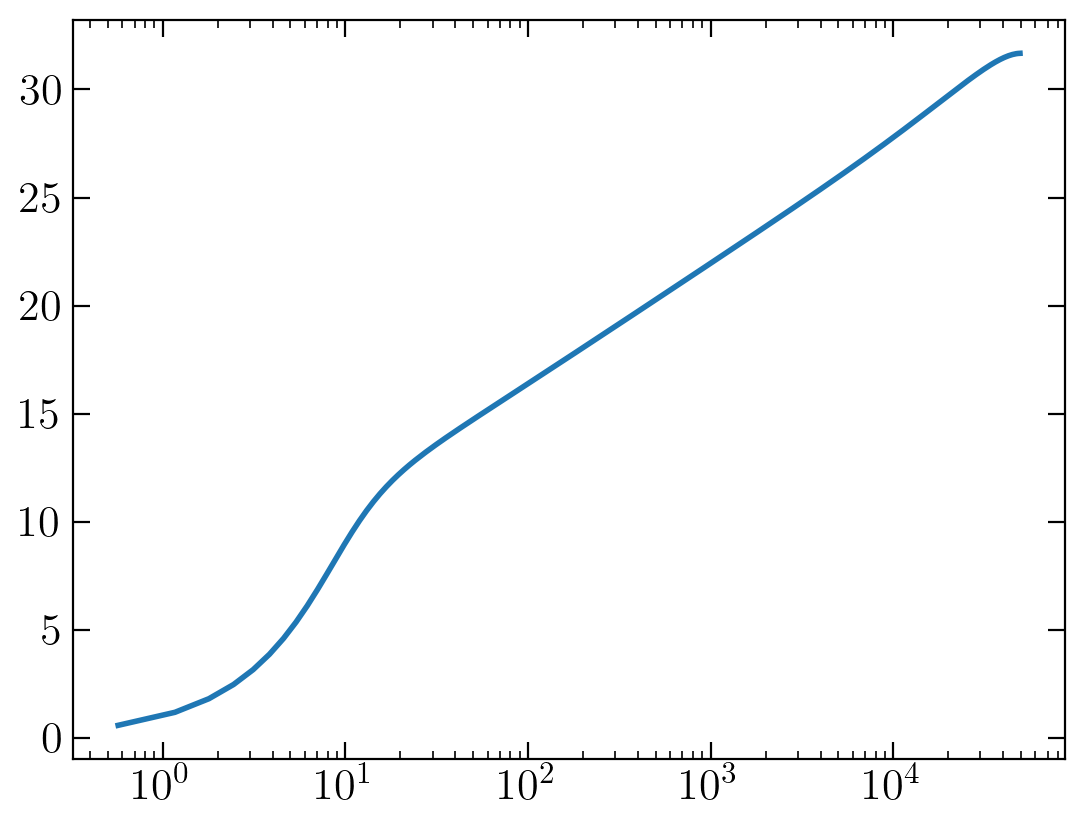

In [13]:
mesh = Mesh(400, 2, 9)

sol = solveRANS(mesh = mesh, ReTau = 50000, turbModel = "SA")

plt.semilogx(sol['ypl'][1:mesh.n//2], sol['u'][1:mesh.n//2], '-', lw=2)

### Example, V2F model for constant $Re^\star_\tau$ case from Patel et al. with different variable property corrections

ReTau  =  950.0
Pr     =  1.0
expRho =  -1.0
expMu  =  0.7
expLam =  0.0
Qvol   =  75.0
CONVERGED! Iteration: 1066, Residual(u) = 9.975912822264302e-07, Time to run 1.8711 seconds
CONVERGED! Iteration: 1034, Residual(u) = 9.983887174903943e-07, Time to run 1.7921 seconds
CONVERGED! Iteration: 1282, Residual(u) = 9.965614562074564e-07, Time to run 2.1734 seconds


Text(0, 0.5, '$u^\\star$')

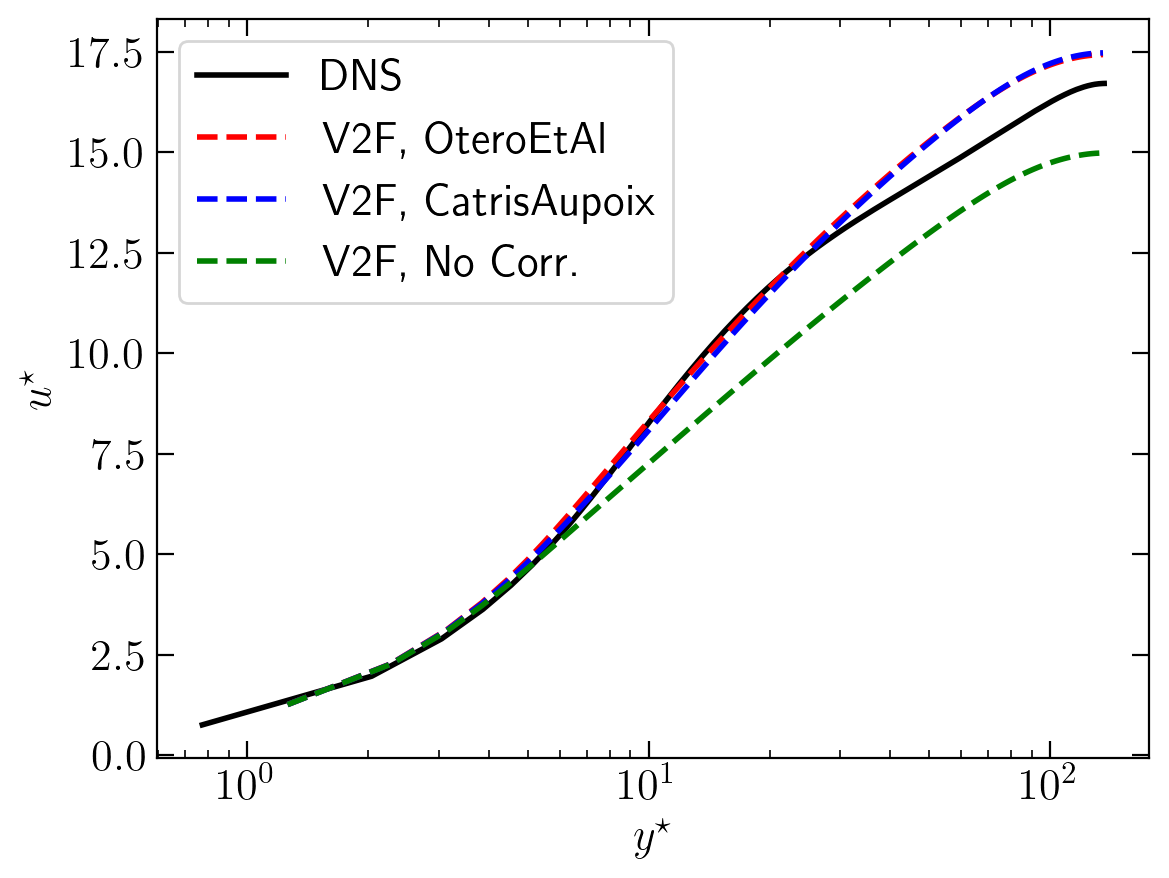

In [14]:
mesh = Mesh(200, 2, 4)


DNS = loadAPdata(dataRepo+'PatelEtAl_gasLike.txt')
# DNS = loadAPdata("DNS_data/PatelEtAl_constReTauStar.txt")
# DNS = loadTLdata('DNS_data/M4.0R200_data.csv')

sol1 = solveRANS(mesh = mesh, 
                yDNS = DNS['y'], rhoDNS = DNS['rho'], muDNS = DNS['mu'], ReTau = DNS['ReTau'], 
                varPropCorr = "OteroEtAl", 
                turbModel = "V2F")

sol2 = solveRANS(mesh = mesh, 
                yDNS = DNS['y'], rhoDNS = DNS['rho'], muDNS = DNS['mu'], ReTau = DNS['ReTau'], 
                varPropCorr = "CatrisAupoix", 
                turbModel = "V2F")

sol3 = solveRANS(mesh = mesh, 
                yDNS = DNS['y'], rhoDNS = DNS['rho'], muDNS = DNS['mu'], ReTau = DNS['ReTau'], 
                varPropCorr = "None", 
                turbModel = "V2F")

plt.semilogx(DNS['yst'], DNS['ust'], 'k-', label = 'DNS', lw=2)
plt.semilogx(sol1['yst'][1:mesh.n//2], sol1['ust'][1:mesh.n//2], 'r--', label = 'V2F, OteroEtAl', lw=2)
plt.semilogx(sol2['yst'][1:mesh.n//2], sol2['ust'][1:mesh.n//2], 'b--', label = 'V2F, CatrisAupoix', lw=2)
plt.semilogx(sol3['yst'][1:mesh.n//2], sol3['ust'][1:mesh.n//2], 'g--', label = 'V2F, No Corr.', lw=2)
plt.legend()
plt.xlabel(r'$y^\star$')
plt.ylabel(r'$u^\star$')

# Plots in book
### SST and SA models 

In [15]:
def solve_SST_SA(DNS):

    sst_corr = solveRANS(mesh = mesh, 
                     ReTau = DNS['ReTau'], 
                     turbModel = "SST", 
                     varPropCorr = "OteroEtAl",
                     yDNS = DNS['y'], rhoDNS = DNS['rho'], muDNS = DNS['mu'])
    
    sst_nocorr = solveRANS(mesh = mesh,
                     ReTau = DNS['ReTau'], 
                     turbModel = "SST", 
                     varPropCorr = "None",
                     yDNS = DNS['y'], rhoDNS = DNS['rho'], muDNS = DNS['mu'])
    
    sa_corr = solveRANS(mesh = mesh, 
                     ReTau = DNS['ReTau'], 
                     turbModel = "SA", 
                     varPropCorr = "OteroEtAl",
                     yDNS = DNS['y'], rhoDNS = DNS['rho'], muDNS = DNS['mu'])
    
    sa_nocorr = solveRANS(mesh = mesh,
                     ReTau = DNS['ReTau'], 
                     turbModel = "SA", 
                     varPropCorr = "None",
                     yDNS = DNS['y'], rhoDNS = DNS['rho'], muDNS = DNS['mu'])
    
    return {'sst_corr':sst_corr, 'sst_nocorr':sst_nocorr, 
            'sa_corr':sa_corr,   'sa_nocorr':sa_nocorr}

In [16]:
mesh = Mesh(160, 2, 5)

DNS_crets = loadAPdata(dataRepo+'PatelEtAl_constReTauStar.txt')

res_crets = solve_SST_SA(DNS_crets)

ReTau  =  395.0
Pr     =  1.0
expRho =  -1.0
expMu  =  -0.5
expLam =  0.0
Qvol   =  95.0
CONVERGED! Iteration: 362, Residual(u) = 9.918865268023789e-07, Time to run 0.4405 seconds
CONVERGED! Iteration: 438, Residual(u) = 9.851669360383336e-07, Time to run 0.5106 seconds
CONVERGED! Iteration: 382, Residual(u) = 9.77623642527783e-07, Time to run 0.2814 seconds
CONVERGED! Iteration: 387, Residual(u) = 9.932356138762717e-07, Time to run 0.2760 seconds


In [17]:
DNS_gasl = loadAPdata(dataRepo+'PatelEtAl_gasLike.txt')

res_gasl = solve_SST_SA(DNS_gasl)

ReTau  =  950.0
Pr     =  1.0
expRho =  -1.0
expMu  =  0.7
expLam =  0.0
Qvol   =  75.0
CONVERGED! Iteration: 380, Residual(u) = 9.990112871044314e-07, Time to run 0.4235 seconds
CONVERGED! Iteration: 485, Residual(u) = 9.938314674404821e-07, Time to run 0.5382 seconds
CONVERGED! Iteration: 356, Residual(u) = 9.78544022495889e-07, Time to run 0.2558 seconds
CONVERGED! Iteration: 355, Residual(u) = 9.988120958830113e-07, Time to run 0.2531 seconds


In [18]:
DNS_TL = loadTLdata(dataRepo+'M4.0R200_data.csv')

res_TL = solve_SST_SA(DNS_TL)

rhow  =  3.44921321
muw   =  0.0001
utau  =  0.0294984408
ReTau =  1017.46412
MaTau =  0.118050441
CONVERGED! Iteration: 371, Residual(u) = 9.751356616639341e-07, Time to run 0.4471 seconds
CONVERGED! Iteration: 452, Residual(u) = 9.924135856459033e-07, Time to run 0.5062 seconds
CONVERGED! Iteration: 370, Residual(u) = 9.971245337701426e-07, Time to run 0.2815 seconds
CONVERGED! Iteration: 374, Residual(u) = 9.82079228002794e-07, Time to run 0.2767 seconds


In [19]:
def plotProfiles(ax, res, color, dashes, DNS, label='', showDNS=True):
    
    # analytic results for viscous sub-layer
    ypLam = 10**np.linspace(np.log10(0.1),np.log10(13),20)
    ax.semilogx(ypLam,ypLam,color='0.6', lw=0.8, dashes=(10,2,2,2))
        
    # semi-empirical result for log-layer
    ypTurb = 10**np.linspace(np.log10(4),np.log10(1200),20) 
    upTurb = 1/0.41*np.log(ypTurb) + 5.2
    ax.semilogx(ypTurb, upTurb,color='0.6', lw=0.8, dashes=(10,2,2,2))

    mew = 1.0
    ms  = 6
    fillstyle = 'none'
    colorDNS = 'k'

    if (showDNS):
        ax.semilogx(DNS['yst'][1:], DNS['ust'][1:], '-', color=colorDNS, lw=2, label='DNS')

    # Model 
    ax.semilogx(res['yst'][1:mesh.n//2], res['ust'][1:mesh.n//2], color=color, dashes=dashes, lw=2, label=label)

    ax.yaxis.set_minor_locator(MultipleLocator(1))

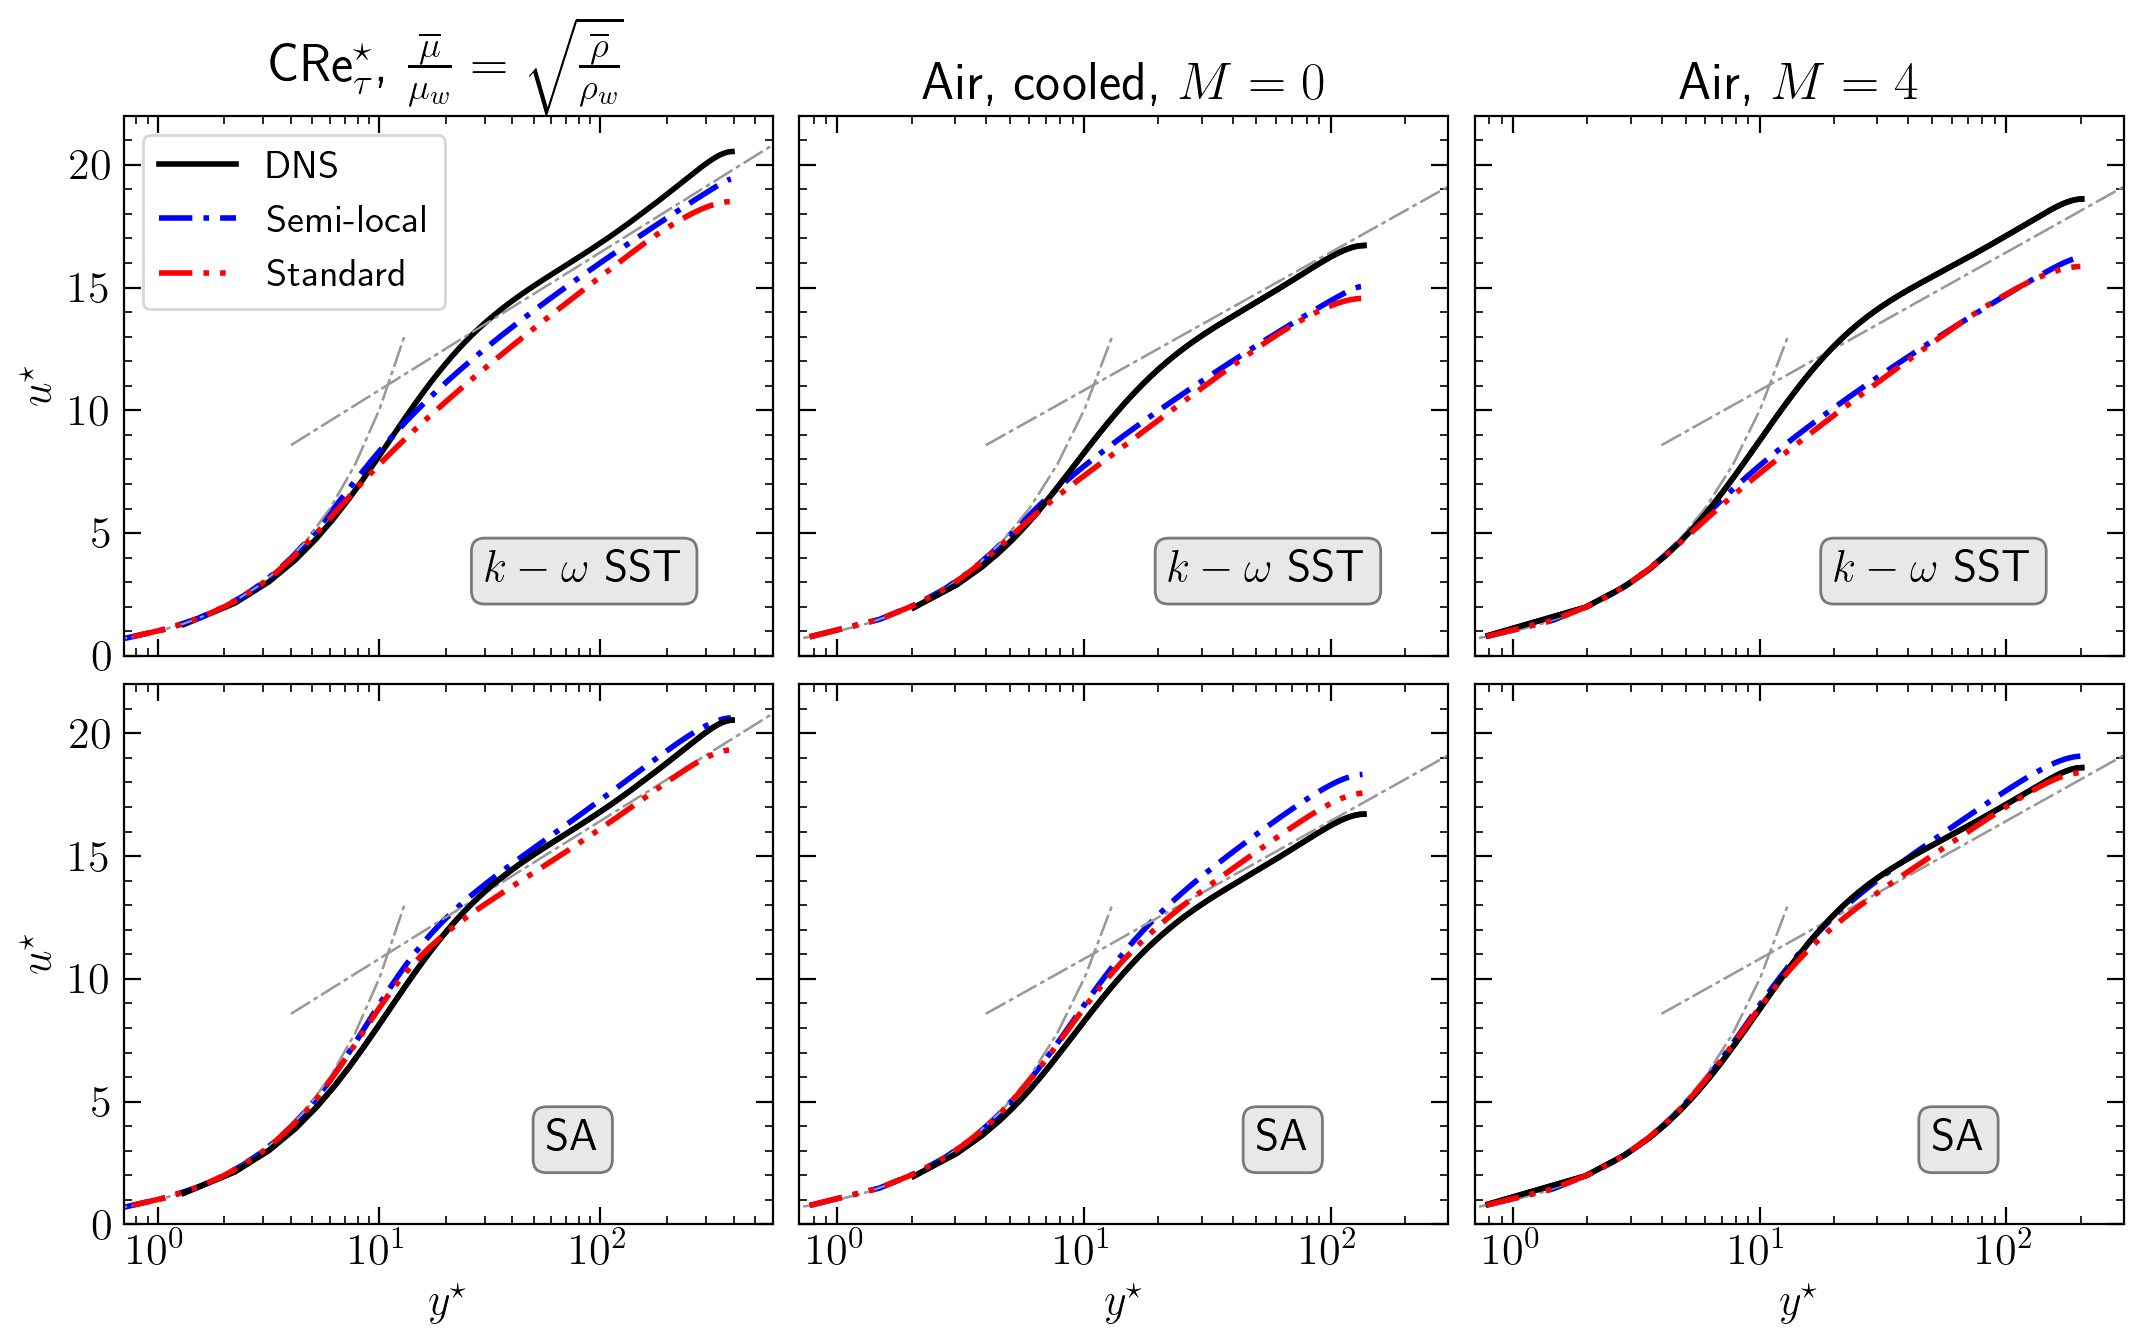

In [20]:
fig, ax = plt.subplots(2,3, figsize=(11, 7), sharex='col', sharey='row')
dashes1 = (6,2,1,2)
dashes2 = (6,2,1,2,1,2)

# case const ReTauStar
plotProfiles(ax[0,0], res_crets['sst_corr'],   'b', dashes1, DNS_crets, label='Semi-local')
plotProfiles(ax[0,0], res_crets['sst_nocorr'], 'r', dashes2, DNS_crets, label='Standard', showDNS=False)

plotProfiles(ax[1,0], res_crets['sa_corr'],   'b', dashes1, DNS_crets)
plotProfiles(ax[1,0], res_crets['sa_nocorr'], 'r', dashes2, DNS_crets)


# case gas like
plotProfiles(ax[0,1], res_gasl['sst_corr'],   'b', dashes1, DNS_gasl)
plotProfiles(ax[0,1], res_gasl['sst_nocorr'], 'r', dashes2, DNS_gasl)

plotProfiles(ax[1,1], res_gasl['sa_corr'],   'b', dashes1, DNS_gasl)
plotProfiles(ax[1,1], res_gasl['sa_nocorr'], 'r', dashes2, DNS_gasl)


# case Trettel and Larsson
plotProfiles(ax[0,2], res_TL['sst_corr'],   'b', dashes1, DNS_TL)
plotProfiles(ax[0,2], res_TL['sst_nocorr'], 'r', dashes2, DNS_TL)

plotProfiles(ax[1,2], res_TL['sa_corr'],   'b', dashes1, DNS_TL)
plotProfiles(ax[1,2], res_TL['sa_nocorr'], 'r', dashes2, DNS_TL)


ax[0,0].set_xlim(0.7, 600)
ax[0,1].set_xlim(0.7, 300)
ax[0,2].set_xlim(0.7, 300)

ax[0,0].set_ylim(0, 22)
ax[1,0].set_ylim(0, 22)

ax[0,0].set_ylabel(r'$u^\star$')
ax[1,0].set_ylabel(r'$u^\star$')

ax[1,0].set_xlabel(r'$y^\star$')
ax[1,1].set_xlabel(r'$y^\star$')
ax[1,2].set_xlabel(r'$y^\star$')



ax[0,0].set_title(r'CRe$^\star_\tau$, $\frac{\overline\mu}{\mu_w} = \sqrt{\frac{\overline\rho}{\rho_w}}$')
ax[0,1].set_title(r'Air, cooled, $M=0$')
ax[0,2].set_title(r'Air, $M=4$')

ax[0,0].legend(loc=2, fontsize=14)

props = dict(boxstyle='round', facecolor='lightgray', alpha=0.5)
ax[0,0].text(30, 3, r'$k-\omega$ SST', rotation=0, bbox=props)
ax[0,1].text(22, 3, r'$k-\omega$ SST', rotation=0, bbox=props)
ax[0,2].text(20, 3, r'$k-\omega$ SST', rotation=0, bbox=props)

ax[1,0].text(57, 3, r'SA', rotation=0, bbox=props)
ax[1,1].text(50, 3, r'SA', rotation=0, bbox=props)
ax[1,2].text(50, 3, r'SA', rotation=0, bbox=props)

plt.tight_layout(w_pad=0.6, h_pad=0.1)


In [21]:
fig.savefig('othermodels.pdf')

### V2F 

In [22]:
def calcV2F(DNS):
    
    v2f_Otero = solveRANS(mesh = mesh, 
                         ReTau = DNS['ReTau'], 
                         turbModel = "V2F", 
                         varPropCorr = "OteroEtAl",
                         yDNS = DNS['y'], rhoDNS = DNS['rho'], muDNS = DNS['mu'])

    v2f_Catris = solveRANS(mesh = mesh, 
                         ReTau = DNS['ReTau'], 
                         turbModel = "V2F", 
                         varPropCorr = "CatrisAupoix",
                         yDNS = DNS['y'], rhoDNS = DNS['rho'], muDNS = DNS['mu'])

    v2f_nocorr = solveRANS(mesh = mesh,
                         ReTau = DNS['ReTau'], 
                         turbModel = "V2F", 
                         varPropCorr = "None",
                         yDNS = DNS['y'], rhoDNS = DNS['rho'], muDNS = DNS['mu'])
    
    return v2f_Otero, v2f_Catris, v2f_nocorr

In [23]:
mesh = Mesh(200, 2, 6)

DNS_crets = loadAPdata(dataRepo+'PatelEtAl_constReTauStar.txt')

crets_v2f_Otero, crets_v2f_Catris, crets_v2f_nocorr = calcV2F(DNS_crets)

ReTau  =  395.0
Pr     =  1.0
expRho =  -1.0
expMu  =  -0.5
expLam =  0.0
Qvol   =  95.0
CONVERGED! Iteration: 1036, Residual(u) = 9.94018528416314e-07, Time to run 1.8103 seconds
CONVERGED! Iteration: 991, Residual(u) = 9.908871562238159e-07, Time to run 1.7444 seconds
CONVERGED! Iteration: 1387, Residual(u) = 9.994940395417134e-07, Time to run 2.3938 seconds


In [24]:
DNS_gasl = loadAPdata(dataRepo+"PatelEtAl_gasLike.txt")

gasl_v2f_Otero, gasl_v2f_Catris, gasl_v2f_nocorr = calcV2F(DNS_gasl)

ReTau  =  950.0
Pr     =  1.0
expRho =  -1.0
expMu  =  0.7
expLam =  0.0
Qvol   =  75.0
CONVERGED! Iteration: 873, Residual(u) = 9.871631104033015e-07, Time to run 1.5100 seconds
CONVERGED! Iteration: 788, Residual(u) = 9.83705001895522e-07, Time to run 1.3753 seconds
CONVERGED! Iteration: 1168, Residual(u) = 9.981685087928312e-07, Time to run 2.0004 seconds


In [25]:
DNS_TL = loadTLdata(dataRepo+'M4.0R200_data.csv')

TL_v2f_Otero, TL_v2f_Catris, TL_v2f_nocorr = calcV2F(DNS_TL)

rhow  =  3.44921321
muw   =  0.0001
utau  =  0.0294984408
ReTau =  1017.46412
MaTau =  0.118050441
CONVERGED! Iteration: 834, Residual(u) = 9.996228361259214e-07, Time to run 1.4322 seconds
CONVERGED! Iteration: 892, Residual(u) = 9.972033003017844e-07, Time to run 1.5490 seconds
CONVERGED! Iteration: 975, Residual(u) = 9.94058617873968e-07, Time to run 1.6599 seconds


In [26]:
def plotProfilesAll(ax, res, color, dashes, DNS, label='', showDNS=True, plotepsDNS=True):

    # analytic results for viscous sub-layer
    ypLam = 10**np.linspace(np.log10(0.1),np.log10(13),20)
    ax[0].semilogx(ypLam,ypLam,color='0.6', lw=0.8, dashes=(10,2,2,2))
        
    # semi-empirical result for log-layer
    ypTurb = 10**np.linspace(np.log10(4),np.log10(1200),20) 
    upTurb = 1/0.41*np.log(ypTurb) + 5.2
    ax[0].semilogx(ypTurb, upTurb,color='0.6', lw=0.8, dashes=(10,2,2,2))

    # DNS
    # yst_ = 10**np.linspace(np.log10(ystDNS[1]), 0.9999*np.log10(ystDNS[-1]), 30)
    # def intp(a):
    #     f = int1d.interp1d(ystDNS, a)
    #     return f(yst_)
    mew = 1.0
    ms  = 6
    fillstyle = 'none'
    colorDNS = 'k'
    # ax.semilogx(yst_[1:], intp(ustDNS)[1:], 'o', color=color, fillstyle = fillstyle, mew=mew, ms = ms)
    if (showDNS):
        ax[0].semilogx(DNS['yst'][1:], DNS['ust'][1:], '-', color=colorDNS, lw=2, label='DNS')

    # Model 
    ax[0].semilogx(res['yst'][1:mesh.n//2], res['ust'][1:mesh.n//2], color=color, dashes=dashes, lw=2, label=label)


    # ruv 
    ax[1].semilogx(DNS['yst'][1:], DNS['ruv'][1:], '-', color=colorDNS, lw=2, label='DNS')
    ax[1].semilogx(res['yst'][1:mesh.n//2], res['ruv'][1:mesh.n//2], color=color, dashes=dashes, lw=2, label=label)

    
    # TKE 
    ax[2].semilogx(DNS['yst'][1:], DNS['rk'][1:], '-', color=colorDNS, lw=2, label='DNS')
    ax[2].semilogx(res['yst'][1:mesh.n//2], res['rho'][1:mesh.n//2]*res['k'][1:mesh.n//2], 
                   color=color, dashes=dashes, lw=2, label=label)
    

    # eps
    if plotepsDNS == True:
        # ystSLS = dnsSLS[:,0]*dnsSLS[:,1]
        # eps    = dnsSLS[:,2]/dnsSLS[:,1]
        ax[3].semilogx(DNS['yst'], DNS['epsSLS'], '-', color=colorDNS, lw=2, label='DNS')
        # ax[3].semilogx(DNS['yst'], DNS['eps'], '-', color=colorDNS, lw=2, label='DNS')

    # DNSeps = eps[1:]
    # ax[3].semilogx(DNS['yst'][1:], DNS['eps'][1:], '-', color=colorDNS, lw=2, label='DNS')
    ReTS = np.sqrt(res['rho'])/res['mu']
    eps = res['rho']**1.5*res['e']/ReTS
    ax[3].semilogx(res['yst'][1:mesh.n//2], 
                   -eps[1:mesh.n//2], 
                   color=color, dashes=dashes, lw=2, label=label)
    

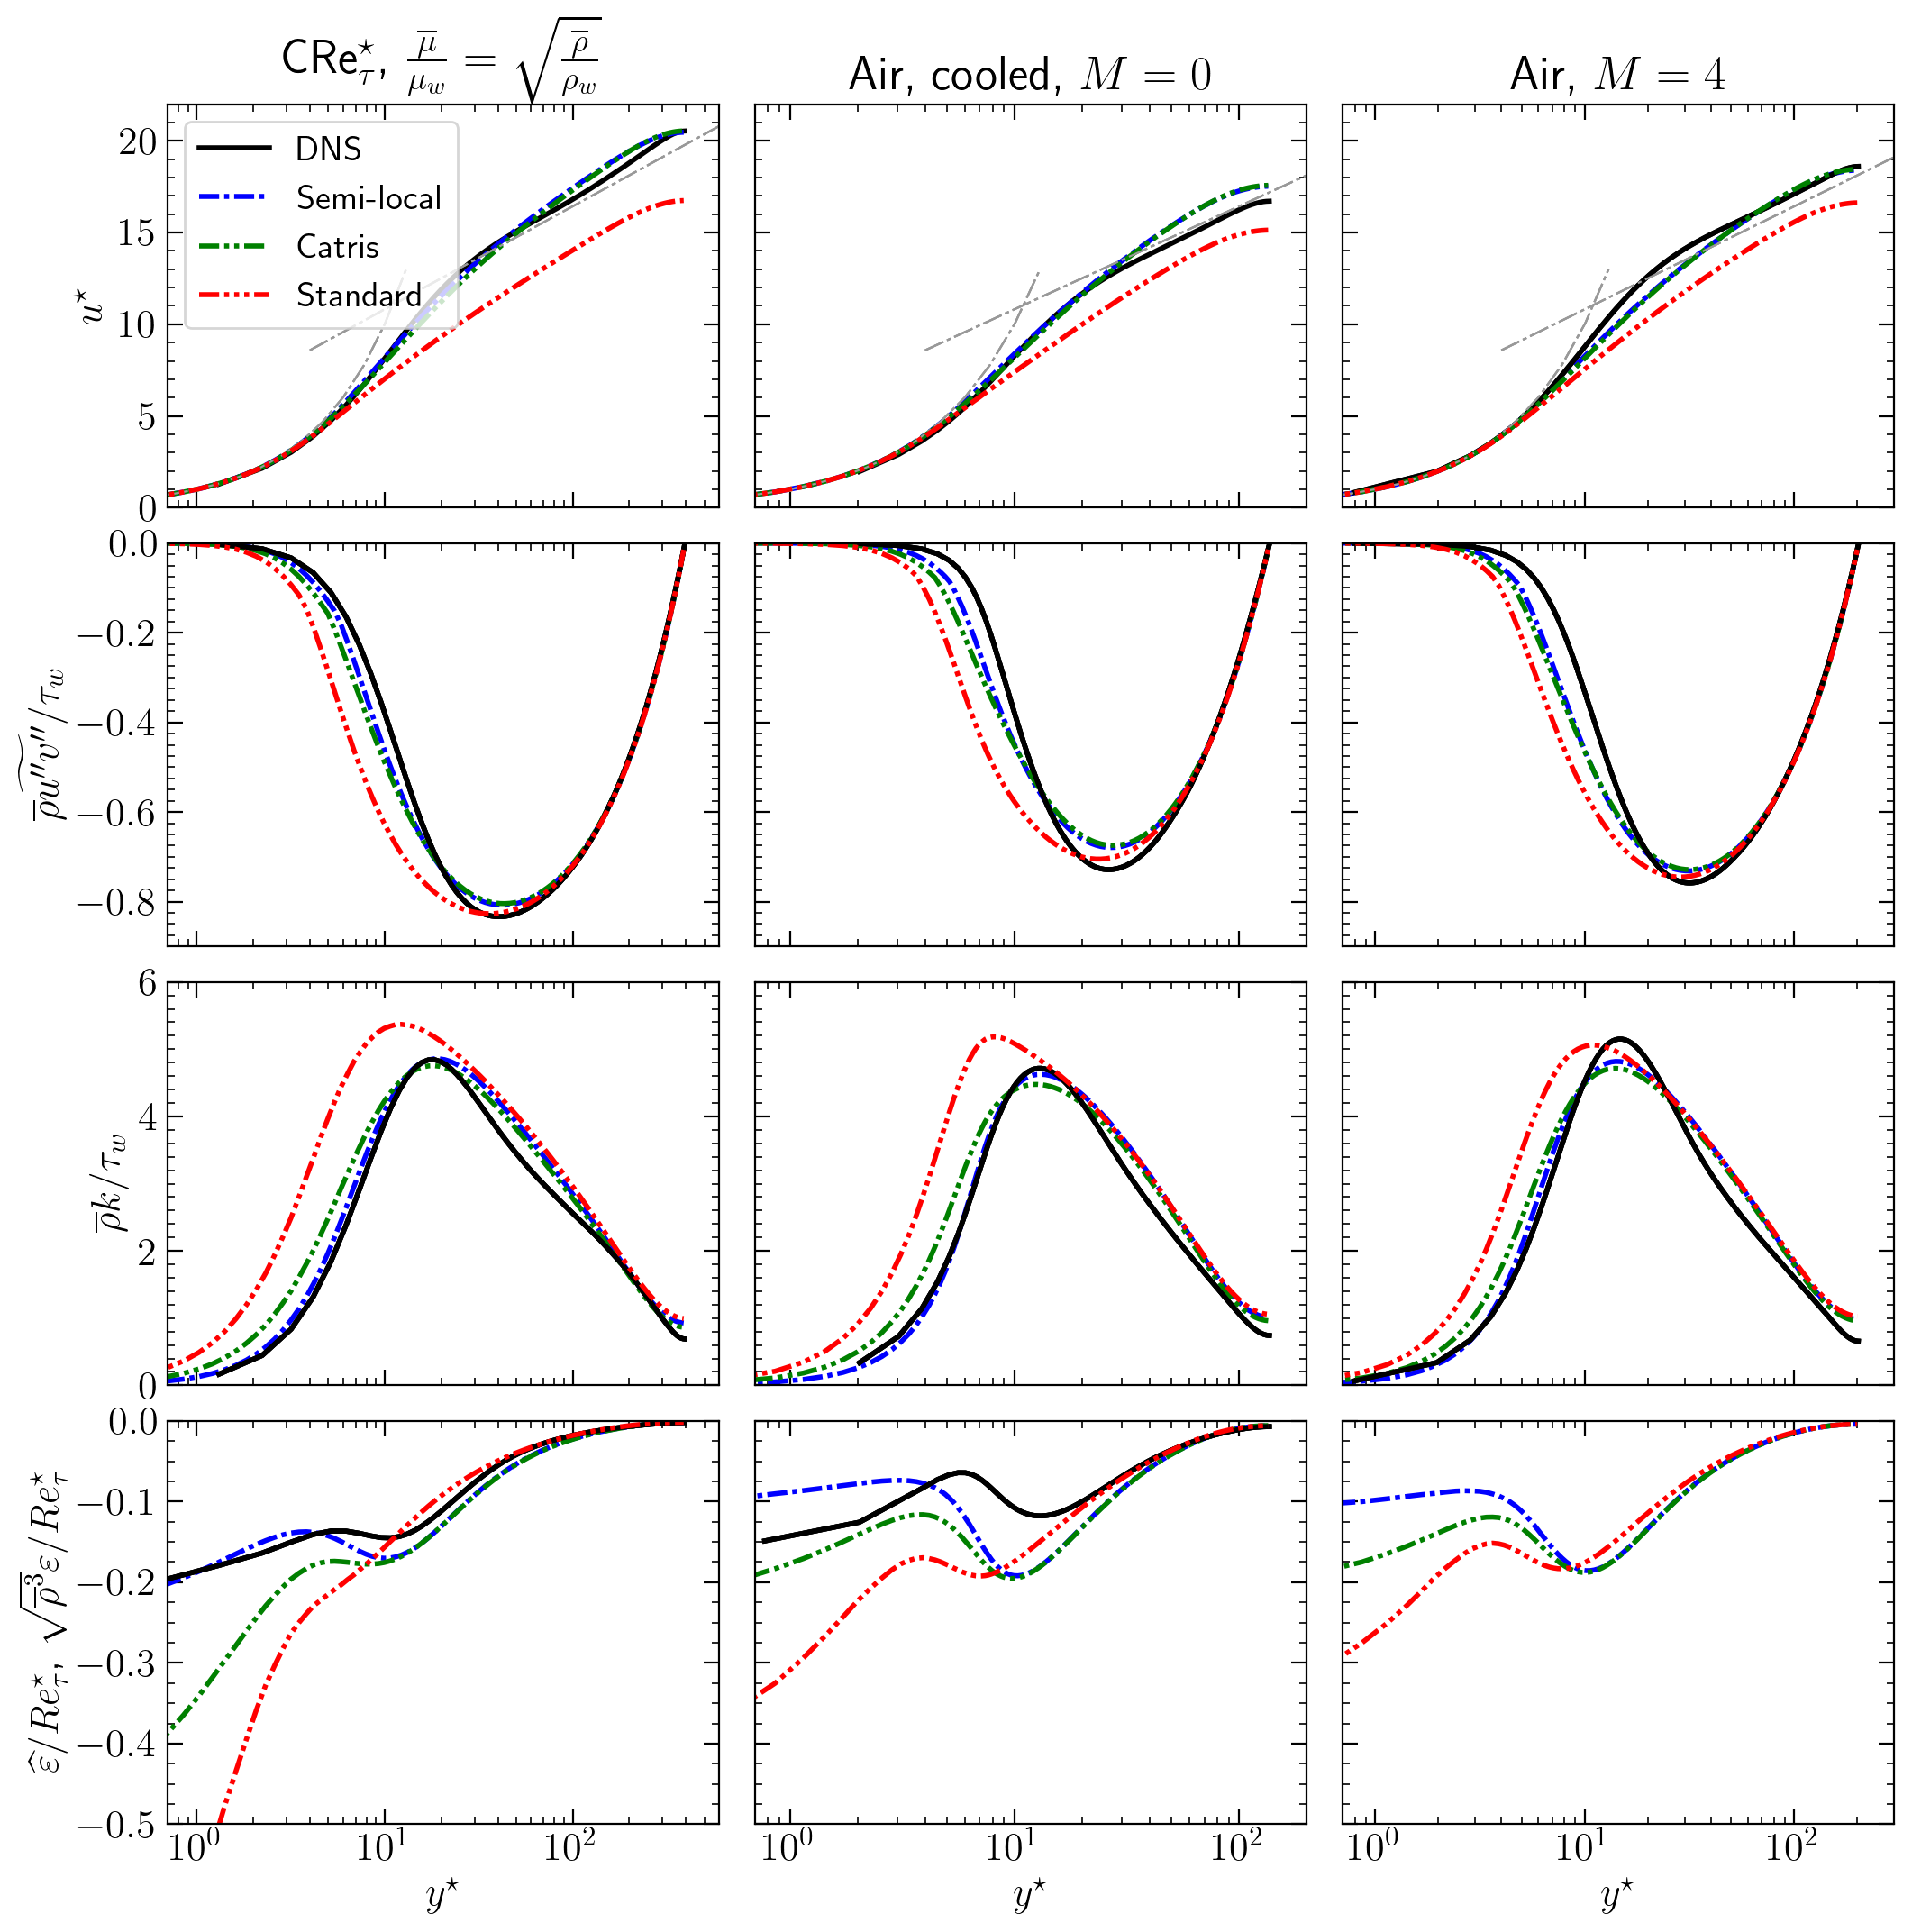

In [27]:
fig, ax = plt.subplots(4,3, figsize=(11, 11), sharex='col', sharey='row')

dashes1 = (4,1,1,1)
dashes2 = (4,1,1,1,1,1)
dashes3 = (4,1,1,1,1,1,1,1)

plotProfilesAll(ax[:,0], crets_v2f_Otero,  'b', dashes1, DNS_crets, label='Semi-local')
plotProfilesAll(ax[:,0], crets_v2f_Catris, 'g', dashes2, DNS_crets, label='Catris', showDNS=False)
plotProfilesAll(ax[:,0], crets_v2f_nocorr, 'r', dashes3, DNS_crets, label='Standard', showDNS=False)

plotProfilesAll(ax[:,1], gasl_v2f_Otero,  'b', dashes1, DNS_gasl, label='Semi-local')
plotProfilesAll(ax[:,1], gasl_v2f_Catris, 'g', dashes2, DNS_gasl, label='Catris', showDNS=False)
plotProfilesAll(ax[:,1], gasl_v2f_nocorr, 'r', dashes3, DNS_gasl, label='Standard', showDNS=False)

plotProfilesAll(ax[:,2], TL_v2f_Otero,  'b', dashes1, DNS_TL, label='Semi-local', plotepsDNS=False)
plotProfilesAll(ax[:,2], TL_v2f_Catris, 'g', dashes2, DNS_TL, label='Catris', plotepsDNS=False)
plotProfilesAll(ax[:,2], TL_v2f_nocorr, 'r', dashes3, DNS_TL, label='Standard', showDNS=False, plotepsDNS=False)


ax[0,0].set_title(r'CRe$^\star_\tau$, $\frac{\overline\mu}{\mu_w} = \sqrt{\frac{\overline\rho}{\rho_w}}$')
ax[0,1].set_title(r'Air, cooled, $M=0$')
ax[0,2].set_title(r'Air, $M=4$')

ax[0,0].set_xlim(0.7, 600)
ax[0,1].set_xlim(0.7, 200)
ax[0,2].set_xlim(0.7, 300)

ax[0,0].set_ylim(0, 22)
ax[1,0].set_ylim(-0.9, 0)
ax[2,0].set_ylim(0, 6)
ax[3,0].set_ylim(-0.5, 0)

ax[0,0].set_ylabel(r'$u^\star$')
ax[1,0].set_ylabel(r'$\overline\rho \widetilde{u^{\prime\prime} v^{\prime\prime}}/\tau_w$')
ax[2,0].set_ylabel(r'$\overline\rho k/\tau_w$')
ax[3,0].set_ylabel(r'$\widehat\varepsilon/Re^\star_\tau$, $\sqrt{\overline\rho^3}\varepsilon/Re^\star_\tau$')


ax[3,0].set_xlabel(r'$y^\star$')
ax[3,1].set_xlabel(r'$y^\star$')
ax[3,2].set_xlabel(r'$y^\star$')

ax[0,0].legend(loc=2, fontsize=14)


ax[0,0].yaxis.set_minor_locator(MultipleLocator(1))
ax[1,0].yaxis.set_minor_locator(MultipleLocator(0.025))
ax[2,0].yaxis.set_minor_locator(MultipleLocator(0.2))
ax[3,0].yaxis.set_minor_locator(MultipleLocator(0.025))


plt.tight_layout(w_pad=0.9, h_pad=0.0)


In [28]:
fig.savefig('resultsV2F.pdf')

### SST with intrinsic compressibility corrections

CONVERGED! Iteration: 563, Residual(u) = 9.918498991324046e-07, Time to run 0.6685 seconds
CONVERGED! Iteration: 516, Residual(u) = 9.934346175962055e-07, Time to run 0.5867 seconds
CONVERGED! Iteration: 601, Residual(u) = 9.955704007626734e-07, Time to run 0.6799 seconds
CONVERGED! Iteration: 563, Residual(u) = 9.91619335761888e-07, Time to run 0.6649 seconds
CONVERGED! Iteration: 463, Residual(u) = 9.932823400152866e-07, Time to run 0.5232 seconds
CONVERGED! Iteration: 621, Residual(u) = 9.979951290080447e-07, Time to run 0.7003 seconds
CONVERGED! Iteration: 563, Residual(u) = 9.899561251386536e-07, Time to run 0.6573 seconds
CONVERGED! Iteration: 437, Residual(u) = 9.970673884082182e-07, Time to run 0.4942 seconds
CONVERGED! Iteration: 662, Residual(u) = 9.986742375472164e-07, Time to run 0.7465 seconds


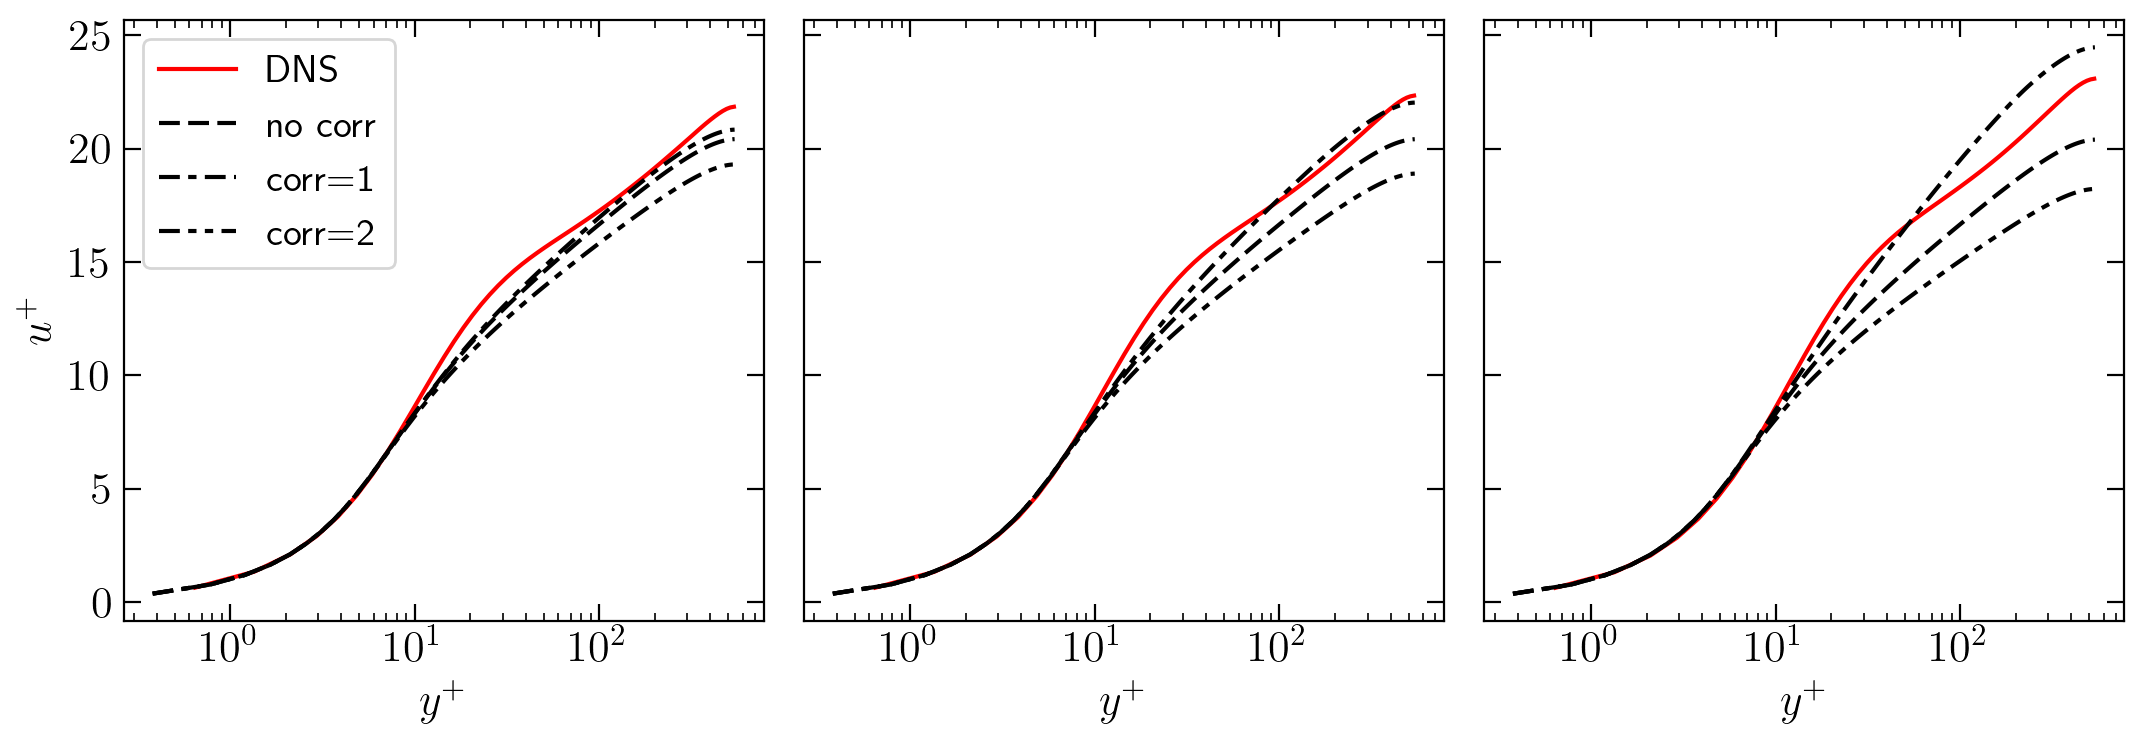

In [29]:
def runSSTwithIntrinsicCompCorr(DNS):
    res1 = solveRANS(mesh = mesh, 
                     ReTau = DNS['ReTau'], 
                     turbModel = "SST", 
                     varPropCorr = "None",
                     yDNS = DNS['y'], rhoDNS = DNS['rho'], muDNS = DNS['mu'], compressCorr=0, Mach=DNS['Mach'])
    
    res2 = solveRANS(mesh = mesh, 
                     ReTau = DNS['ReTau'], 
                     turbModel = "SST", 
                     varPropCorr = "None",
                     yDNS = DNS['y'], rhoDNS = DNS['rho'], muDNS = DNS['mu'], compressCorr=1, Mach=DNS['Mach'])
    
    res3 = solveRANS(mesh = mesh, 
                     ReTau = DNS['ReTau'], 
                     turbModel = "SST", 
                     varPropCorr = "None",
                     yDNS = DNS['y'], rhoDNS = DNS['rho'], muDNS = DNS['mu'], compressCorr=2, Mach=DNS['Mach'])
    return res1, res2, res3


def plotResultsSSTwithIntrinsicCompCorr(ax):
    ax.semilogx(DNS['yst'][1:len(DNS['y'])//2], DNS['ust'][1:len(DNS['y'])//2], 'r', label='DNS')
    ax.semilogx(res1['yst'][1:mesh.n//2], res1['ust'][1:mesh.n//2], 'k', dashes=(5,2),         label='no corr')
    ax.semilogx(res2['yst'][1:mesh.n//2], res2['ust'][1:mesh.n//2], 'k', dashes=(5,2,2,2),     label='corr=1')
    ax.semilogx(res3['yst'][1:mesh.n//2], res3['ust'][1:mesh.n//2], 'k', dashes=(5,2,2,2,2,2), label='corr=2')


fig, ax = plt.subplots(1,3, figsize=(11, 4), sharey='row')

mesh = Mesh(200,2,5)

DNS = loadHasanData(dataRepo+'HasanEtAlMach2.csv')
res1, res2, res3 = runSSTwithIntrinsicCompCorr(DNS)
plotResultsSSTwithIntrinsicCompCorr(ax[0])

DNS = loadHasanData(dataRepo+'HasanEtAlMach3.csv')
res1, res2, res3 = runSSTwithIntrinsicCompCorr(DNS)
plotResultsSSTwithIntrinsicCompCorr(ax[1])

DNS = loadHasanData(dataRepo+'HasanEtAlMach4.csv')
res1, res2, res3 = runSSTwithIntrinsicCompCorr(DNS)
plotResultsSSTwithIntrinsicCompCorr(ax[2])

ax[0].set_ylabel(r'$u^+$')
ax[0].set_xlabel(r'$y^+$')
ax[1].set_xlabel(r'$y^+$')
ax[2].set_xlabel(r'$y^+$')
ax[0].legend(loc=2, fontsize=14)
plt.tight_layout(w_pad=0.9, h_pad=0.0)